# Proyecto- Segmentación en grupos de acuerdo a características de pacientes

**Integrantes**: Maria Fernanda De La Hoz, Silvana Sandoval y Gabriela Soler 


## Objetivo del proyecto

Este proyecto tiene el objetivo de incorporar herramientas de Inteligencia Artificial para incrementar la eficiencia de la prestación de servicios a los usuarios en las diferentes IPS asociadas, teniendo en cuenta que en el contexto del triage, la agrupación puede ser útil para la toma de decisiones.

## Importación de las librerías relevantes

Este primer paso es esencial ya que estas librerías son las que nos permitirán ejecutar los algoritmos y hacer los análisis relevantes para comprender cuál de los modelos que usamos es el óptimo para solucionar el problema de este proyecto.

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Importación de los datos

In [196]:
data = pd.read_csv("202420_Laboratorio 2 - Agrupación_202420_Laboratorio_2_-_Agrupación_data.csv", encoding="latin1", sep=",")

## Entedimiento de los datos

Para empezar los pasos de entendimiento de los datos, es importante ver qué filas lo constituyen.

In [197]:

print(data.head())

   Grupo  Sexo  Edad  Modo_Llegada  Lesion  Queja_Principal  Estado_Mental  \
0      2     2    49             2       1  ant. chest pain              1   
1      2     2    30             4       1         headache              1   
2      2     1    61             3       2  ant. chest pain              1   
3      2     2    61             3       1         headache              1   
4      1     2    67             3       1    fever & chill              1   

   Dolor dolor_NRS    SBP  ...    BT  Saturacion  KTAS_enfermera  \
0      1         2  150.0  ...  36.2        98.0               2   
1      1         4  140.0  ...  36.3        99.0               3   
2      1         3  100.0  ...  36.4        98.0               4   
3      1         4  120.0  ...  36.5        99.0               4   
4      0    #BOÃ!  143.0  ...  38.1         NaN               4   

                Diagnostico_En_Urgencias  Disposicion  KTAS_experto  \
0                   Ischaemic chest pain           

Ahora, vamos a ver el número de registros y de columnas con el que contamos. Esto nos permitirá saber, en total, qué datos tenemos para entrenar los modelos de los que haremos uso en este laboratorio.

In [198]:
data.shape

(1000, 23)

Luego, haremos uso de la función describe() de los DataFrames de Pandas. Esto se hace con el fin de entender cuáles son las medidas de tendencia central (media, desviación estandar, moda), maximos, mínimos y los quartiles de las variables númericas. Lo anterior da una primera aproximación sobre cómo están organizados los datos

In [199]:
print(data.describe())

             Grupo         Sexo         Edad  Modo_Llegada     Lesion  \
count  1000.000000  1000.000000  1000.000000   1000.000000  1000.0000   
mean      1.450000     1.514000    53.892000      2.811000     1.2000   
std       0.497743     0.500054    19.826483      0.796186     0.4002   
min       1.000000     1.000000    16.000000      1.000000     1.0000   
25%       1.000000     1.000000    36.000000      2.000000     1.0000   
50%       1.000000     2.000000    56.000000      3.000000     1.0000   
75%       2.000000     2.000000    70.250000      3.000000     1.0000   
max       2.000000     2.000000    94.000000      7.000000     2.0000   

       Estado_Mental        Dolor         SBP         DBP          HR  \
count    1000.000000  1000.000000  983.000000  979.000000  988.000000   
mean        1.103000     0.562000  133.485249   79.566905   84.400810   
std         0.431946     0.496389   27.156136   15.174593   16.297428   
min         1.000000     0.000000   50.000000   31

### Outliers

Ahora vamos a hacer diagramas de cajas y bigotes para el data frame. Esto lo hacemos para poder identificara aquellas clases que tienen outliers muy extremos, lo cual nos permitirá determinar el tratamiento correcto para estos datos ya que pueden ocasionar problemas en algortimos como K-Means que son sensibles a los datos extremos.

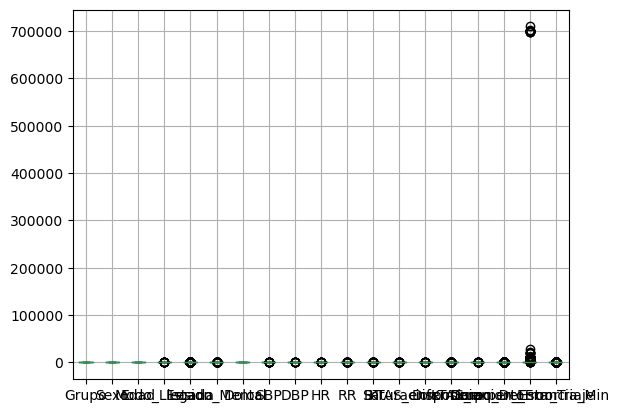

<Figure size 5000x4000 with 0 Axes>

In [200]:
data.boxplot()
plt.figure(figsize=(50, 40))
# Show the plot
plt.show()

Ahora veremos en detalle aquellas clases que tienen outliers para poder determinar si son datos muy diferentes al resto de los datos y se debe hacer una limpieza o si, por el contrario, se pueden dejar para que se pueda hacer una agrupación a partir de estos. Además, esto  nos permitirá identificar si hay valores que no deberían estar en el conjunto de datos ya que se salen de los rangos permitidos. Para esto veremos las clases de Duración_Estancia_Min, Disposicion, HR, SBP, Lesion y Estado Mental.

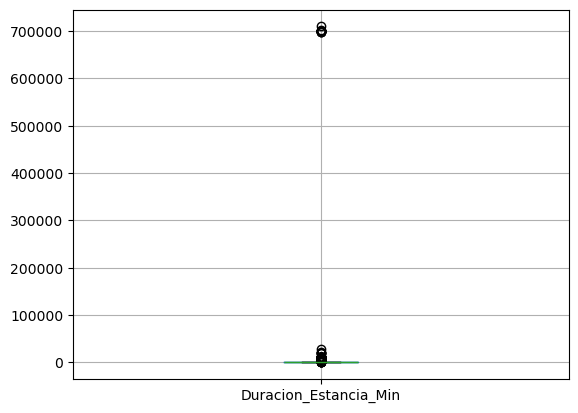

In [201]:
data.boxplot(column=['Duracion_Estancia_Min'])
plt.show()

# Identify outliers based on IQR
Q1 = data['Duracion_Estancia_Min'].quantile(0.25)
Q3 = data['Duracion_Estancia_Min'].quantile(0.75)
IQR = Q3 - Q1


Como se puede ver en la gráfica de Duración_Estancia_Min, si bien hay bastantes outliers, la mayoría estan por debadjo de los 50 mil minutos y no están tan lejanos del diagrama de cajas y bigotes. Sin embargo, hay unos cuantos datos que estan sober 600000 minutos que son bastante lejanos a los demás datos. Esto sería un problema para los algoritmos que vamos a entrenar ya que uno de ellos usa la media de los datos, por lo cual todos los outliers de esta clase que estén por encima de 50000 minutos se eliminarán.

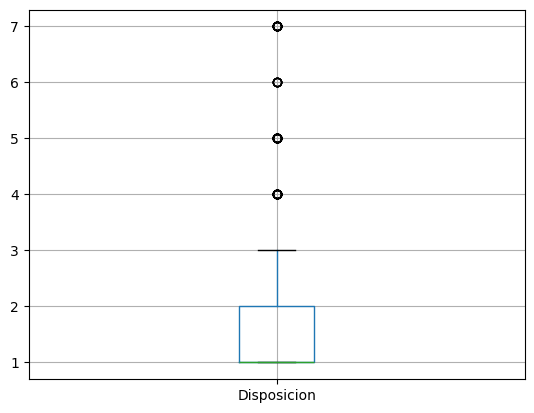

In [202]:
data.boxplot(column=['Disposicion'])
plt.show()

# Identify outliers based on IQR
Q1 = data['Disposicion'].quantile(0.25)
Q3 = data['Disposicion'].quantile(0.75)
IQR = Q3 - Q1


Si bien en la gráfica de cajas y bigores de Disposicion hay outliers, estos no constituyen un problema para los algoritmos ya que son datos permitidos y reflejan comportamientos reales que pueden tener los pacientes que llegan a urgencias y borrarlos podría causar un sesgo ante estas situaciones. Adicionalmente, esta variable es categórica, por lo cual estos número representan el estado en el que llega el paciente y qué tipo de atención requiere.

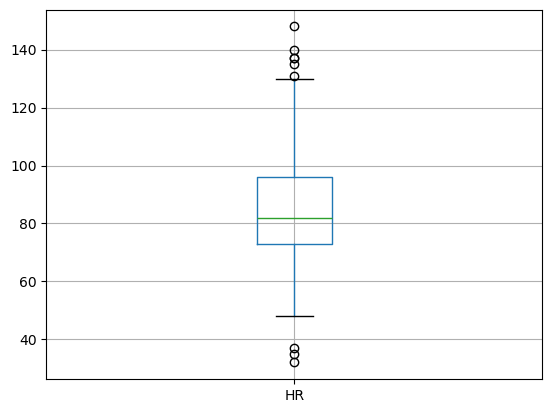

In [203]:
data.boxplot(column=['HR'])
plt.show()

# Identify outliers based on IQR
Q1 = data['HR'].quantile(0.25)
Q3 = data['HR'].quantile(0.75)
IQR = Q3 - Q1


Si bien en la gráfica de cajas y bigores de HR hay outliers, estos no constituyen un problema para los algoritmos ya que son datos permitidos y reflejan comportamientos reales que pueden tener los pacientes que llegan a urgencias y borrarlos podría causar un sesgo ante estas situaciones.

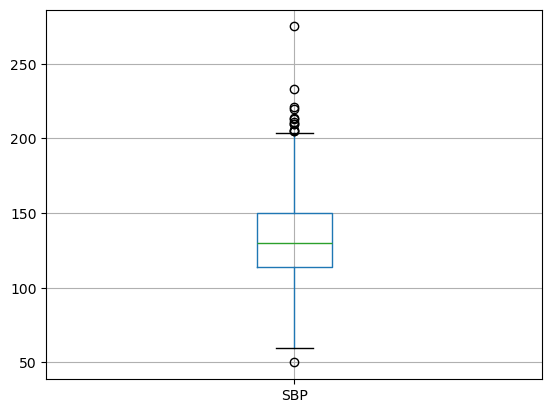

In [204]:
data.boxplot(column=['SBP'])
plt.show()

# Identify outliers based on IQR
Q1 = data['SBP'].quantile(0.25)
Q3 = data['SBP'].quantile(0.75)
IQR = Q3 - Q1


Si bien en la gráfica de cajas y bigores de SBP hay outliers, estos no constituyen un problema para los algoritmos ya que son datos permitidos y reflejan comportamientos reales que pueden tener los pacientes que llegan a urgencias y borrarlos podría causar un sesgo ante estas situaciones.

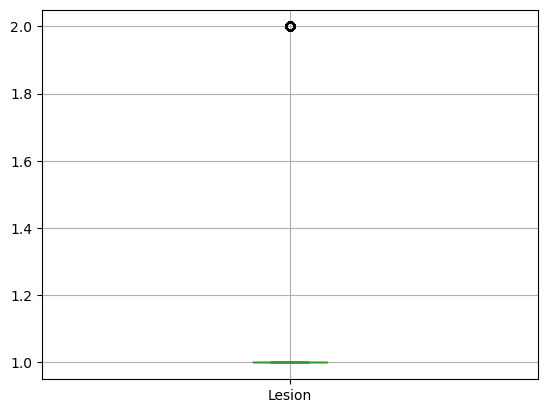

In [205]:
data.boxplot(column=['Lesion'])
plt.show()

# Identify outliers based on IQR
Q1 = data['Lesion'].quantile(0.25)
Q3 = data['Lesion'].quantile(0.75)
IQR = Q3 - Q1


Si bien en la gráfica de cajas y bigores de Lesion hay outliers, estos no constituyen un problema para los algoritmos ya que son datos permitidos y reflejan comportamientos reales que pueden tener los pacientes que llegan a urgencias y borrarlos podría causar un sesgo ante estas situaciones. Adicionalmente, esta variable se considera categórica con 1= sí hay lesión y 2=No hay.

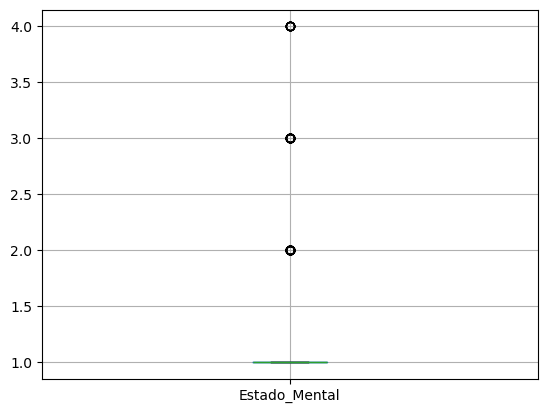

In [206]:
from matplotlib import pyplot as plt


data.boxplot(column=['Estado_Mental'])
plt.show()

# Identify outliers based on IQR
Q1 = data['Estado_Mental'].quantile(0.25)
Q3 = data['Estado_Mental'].quantile(0.75)
IQR = Q3 - Q1


Si bien en la gráfica de cajas y bigores de Estado Mental hay outliers, estos no constituyen un problema para los algoritmos ya que son datos permitidos y reflejan comportamientos reales que pueden tener los pacientes que llegan a urgencias y borrarlos podría causar un sesgo ante estas situaciones. Adicionalmente, esta variable se considera categórica donde los números representan los diferentes estados mentales en los que llegó el paciente, la cual es información valiosa.

### Datos duplicados y nulos

Ahora veremos los datos duplicados y nulos. Comprobar el número de registros que tienen estos datos es sumamente importante ya que los primero pueden causar sesgos en los modelos, y los segundos tienen que ser tratados de alguna manera para que tengan un comportamiento similar a los demás datos.

In [207]:
data.isnull().sum()

Grupo                         0
Sexo                          0
Edad                          0
Modo_Llegada                  0
Lesion                        0
Queja_Principal               0
Estado_Mental                 0
Dolor                         0
dolor_NRS                     0
SBP                          17
DBP                          21
HR                           12
RR                           15
BT                           11
Saturacion                  556
KTAS_enfermera                0
Diagnostico_En_Urgencias      1
Disposicion                   0
KTAS_experto                  0
Grupo_De_Error                0
Duracion_Estancia_Min         0
Duracion_KTAS_Min             0
Error_Triaje                  0
dtype: int64

Vamos a ver el porcentaje de datos faltantes para decidir si borrar columnas o reemplazar por medias.

In [208]:
features = ["Sexo", "Modo_Llegada", "Lesion", "Estado_Mental", "Dolor", "SBP", "DBP", "HR", "RR", "Saturacion", "Disposicion"]

data[["Duracion_Estancia_Min"] + features].isnull().sum() / data.shape[0] * 100

Duracion_Estancia_Min     0.0
Sexo                      0.0
Modo_Llegada              0.0
Lesion                    0.0
Estado_Mental             0.0
Dolor                     0.0
SBP                       1.7
DBP                       2.1
HR                        1.2
RR                        1.5
Saturacion               55.6
Disposicion               0.0
dtype: float64

Ahora, revisaremos los duplicados para tener una idea de cuantos registros serán borrados para evitar sesgos

In [209]:
duplicate_rows = data.duplicated().sum()
print(f"Número de filas duplicadas: {duplicate_rows}")

Número de filas duplicadas: 33


### Número de categorias en las variables categóricas con tipo de datos Object.

Esto se hace con el fin de saber cuántas categorías tienen las variables categoricas para poder decidir si se reemplazan con un encoder o si simplemente se elimina la columna ya que estas, al ser tipo object, no son procesadas por los algoritmos de agrupación como K Means que solo trabajan con datos numéricos. Las categorias con las trabajaremos son: Queja_Principal, dolor_NRS, y Diagnostico_En_Urgencias.

In [210]:
data["Queja_Principal"].value_counts()

Queja_Principal
abd pain                               62
dizziness                              53
dyspnea                                45
ant. chest pain                        37
fever                                  29
                                       ..
hand laceration                         1
Sexual Abuse of Adult                   1
laceration, scalp                       1
right lower quadrant abdominal pain     1
otalgia, Rt.                            1
Name: count, Length: 347, dtype: int64

In [211]:
data["dolor_NRS"].value_counts()

dolor_NRS
#BOÃ!    440
3         209
4         111
5         109
6          59
2          31
7          27
8           8
10          3
1           2
9           1
Name: count, dtype: int64

In [212]:
data["Diagnostico_En_Urgencias"].value_counts()

Diagnostico_En_Urgencias
Acute gastroenteritis                                   39
Headache                                                23
Dizziness                                               20
Unspecified abdominal pain                              19
Ischaemic chest pain                                    17
                                                        ..
Colon cancer, sigmoid                                    1
Postnasal drip syndrome                                  1
Other specified diabetes mellitus, with hypoglycemia     1
Open wound of finger(s) without damage to nail           1
Traumatic secondary and recurrent haemorrhage            1
Name: count, Length: 489, dtype: int64

Como se puede apreciar, en general, se tienen más de 10 o más categorias, una de ellas siendo datos nulos. Esto cuando se utiliza un encoder puede causar que hayan demasiados números, lo cual puede causar problemas en el momento de hacer la agrupación, por lo cual sería recomendable borrarlos.

## Limpieza de los datos

### Análisis de las variables para la implementación del proyecto

*Variables Categóricas:*

Grupo: Es una variable importante porque parece clasificar a los pacientes en grupos que queremos optimizar.

Sexo, Modo_Llegada, Lesión, Estado_Mental, Dolor: Estas variables categorizadas probablemente influyan en la clasificación y deberían codificarse adecuadamente.

*Variables de Severidad:*
KTAS_Enfermera y KTAS_Experto: Estas escalas son importantes para evaluar la urgencia de los pacientes. Es clave tenerlas en cuenta en el modelo de agrupamiento.

Disposición: Esta variable refleja qué pasó con el paciente después de la evaluación, lo que podría ser útil para encontrar patrones en los resultados del tratamiento.

*Variables Numéricas:*

Las variables fisiológicas como SBP (Presión Arterial Sistólica), DBP (Presión Diastólica), HR (Frecuencia Cardíaca), RR (Frecuencia Respiratoria), BT (Temperatura Corporal), y Saturación (Oxígeno) son críticas para describir el estado físico del paciente.

Variables de tiempo como Duración_Estancia_Min y Duración_KTAS_Min también son importantes porque podrían ayudar a analizar la eficiencia de la atención.

*Variables que podrían tener ruido:*

Grupo_Error, Error_Triaje: Si estamos trabajando para hacer agrupamientos basados en la condición de los pacientes, estas columnas relacionadas con errores podrían introducir ruido o ser útiles para analizar el rendimiento de los grupos predichos.

### Manejo de variables faltantes

Para las variables críticas (por ejemplo, las fisiológicas y de severidad), podemos usar imputación. Es por esto que identificaremos cuáles columnas tienen valores faltantes y cuántos faltan:

Para las variables fisiológicas con pocos valores faltantes (SBP, DBP, HR, RR, BT):
Podemos usar imputación con la mediana. La mediana es robusta a valores atípicos y adecuada para variables fisiológicas.

Para la variable Saturacion, que tiene más del 50% de los datos faltantes:
Podríamos considerar imputar con la mediana también, pero como tiene demasiados valores faltantes, otra opción sería eliminar esta columna si no es esencial para el análisis.

Para Diagnostico_En_Urgencias, que tiene solo un valor faltante:
Imputar con el valor más frecuente será una estrategia razonable.

### Copia de los datos

Para empezar la limpieza de los datos, vamos a hacer una copia de los datos para evitar dañar el conjunto original.

In [213]:
#Iniciaremos creando una copia de los datos para realizar un preprocesamiento
dataCopy = data.copy()

Luego, vamos a eliminar los datos duplicados. Esto se hace con el objetivo de evitar sesgos en el modelo.

In [214]:
dataCopy = dataCopy.drop_duplicates()

Después de borrar los duplicados, procederemos a borrar la columna de Saturacion ya que sus registros faltantes son más el 50%, por lo cual se puede inferir que no aporta mucha información relevante para el modelo.

In [215]:
dataCopy = dataCopy.drop(columns=['Saturacion'])

Ahora procedermos a eliminar las columnas categóricas ya que estas tienen muchas clases, lo cual podría causar problemas al momento de transformarlas en númericas.

In [216]:
dataCopy = dataCopy.drop(columns=['Diagnostico_En_Urgencias'], axis=1)
dataCopy = dataCopy.drop(columns=['Queja_Principal'], axis=1)
dataCopy = dataCopy.drop(columns=['dolor_NRS'], axis=1)
dataCopy = dataCopy.drop(columns=['Duracion_KTAS_Min'], axis=1)

In [217]:
dataCopy.sample(5)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Estado_Mental,Dolor,SBP,DBP,HR,RR,BT,KTAS_enfermera,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Error_Triaje
24,1,1,72,3,1,1,1,131.0,54.0,69.0,16.0,37.4,4,1,4,0,133,0
523,2,2,56,3,1,1,1,110.0,70.0,94.0,20.0,36.2,4,1,4,0,696,0
431,2,2,46,3,2,1,0,120.0,80.0,80.0,20.0,36.5,2,2,2,0,989,0
517,1,2,26,3,1,1,0,107.0,56.0,90.0,18.0,36.9,4,1,4,0,77,0
55,2,2,40,3,1,1,1,110.0,80.0,80.0,20.0,36.4,5,1,5,0,60,0


Después, borraremos los outliers muy extremos de la variable Duración_Estancia_Min. Esto lo vamos a hacer a partir de del valor de 50.000 ya que hay valores muy extremos sobre este valore que pueden alterar la forma en la que K-Means genera los grupos.

In [218]:
dataCopy = dataCopy[dataCopy["Duracion_Estancia_Min"]<=50000]

In [219]:
# Imputar las variables fisiológicas con la mediana
dataCopy['SBP'].fillna(dataCopy['SBP'].median(), inplace=True)
dataCopy['DBP'].fillna(dataCopy['DBP'].median(), inplace=True)
dataCopy['HR'].fillna(dataCopy['HR'].median(), inplace=True)
dataCopy['RR'].fillna(dataCopy['RR'].median(), inplace=True)
dataCopy['BT'].fillna(dataCopy['BT'].median(), inplace=True)

C:\Users\silva\AppData\Local\Temp\ipykernel_35164\3758273055.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataCopy['SBP'].fillna(dataCopy['SBP'].median(), inplace=True)
C:\Users\silva\AppData\Local\Temp\ipykernel_35164\3758273055.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

Luego, vamos a eliminar los datos duplicados. Esto se hace con el objetivo de evitar sesgos en el modelo.

In [220]:
print(dataCopy.isnull().sum())

Grupo                    0
Sexo                     0
Edad                     0
Modo_Llegada             0
Lesion                   0
Estado_Mental            0
Dolor                    0
SBP                      0
DBP                      0
HR                       0
RR                       0
BT                       0
KTAS_enfermera           0
Disposicion              0
KTAS_experto             0
Grupo_De_Error           0
Duracion_Estancia_Min    0
Error_Triaje             0
dtype: int64


Ya que solucionamos el problema de las variables faltantes, procederemos al tratamiento de las variables categóricas. Como los algoritmos de agrupamiento requieren variables numéricas, vamos a convertir las variables categóricas a un formato numérico.

Utilizaremos Label Encoding para variables ordinales como KTAS_Enfermera, Estado_Mental, y Disposición, donde los valores tienen un orden implícito, y One-Hot Encoding para variables nominales como Modo_Llegada y Lesion.

In [221]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
dataCopy['KTAS_Enfermera'] = le.fit_transform(dataCopy['KTAS_enfermera'])
dataCopy['Estado_Mental'] = le.fit_transform(dataCopy['Estado_Mental'])
dataCopy['Disposición'] = le.fit_transform(dataCopy['Disposicion'])

dataCopy = pd.get_dummies(dataCopy, columns=['Modo_Llegada', 'Lesion', 'Sexo'], drop_first=True)

In [222]:
dataCopy.sample(5)

,Grupo,Edad,Estado_Mental,Dolor,SBP,DBP,HR,RR,BT,KTAS_enfermera,...,KTAS_Enfermera,Disposición,Modo_Llegada_2,Modo_Llegada_3,Modo_Llegada_4,Modo_Llegada_5,Modo_Llegada_6,Modo_Llegada_7,Lesion_2,Sexo_2
499,1,73,0,0,200.0,100.0,96.0,20.0,36.0,3,...,2,0,True,False,False,False,False,False,False,False
452,2,77,0,1,150.0,100.0,88.0,20.0,36.2,4,...,3,1,False,False,True,False,False,False,True,True
405,1,21,0,0,144.0,97.0,117.0,20.0,36.2,4,...,3,0,False,True,False,False,False,False,False,False
847,1,27,0,0,86.0,77.0,97.0,16.0,37.3,2,...,1,1,False,True,False,False,False,False,False,True
757,1,86,0,0,213.0,91.0,78.0,16.0,37.1,3,...,2,0,False,True,False,False,False,False,False,False


In [223]:
print(dataCopy.head())

   Grupo  Edad  Estado_Mental  Dolor    SBP   DBP     HR    RR    BT  \
0      2    49              0      1  150.0  90.0   92.0  20.0  36.2   
1      2    30              0      1  140.0  80.0   76.0  20.0  36.3   
2      2    61              0      1  100.0  60.0   84.0  20.0  36.4   
3      2    61              0      1  120.0  70.0   76.0  20.0  36.5   
4      1    67              0      0  143.0  70.0  130.0  20.0  38.1   

   KTAS_enfermera  ...  KTAS_Enfermera  Disposición  Modo_Llegada_2  \
0               2  ...               1            1            True   
1               3  ...               2            6           False   
2               4  ...               3            0           False   
3               4  ...               3            0           False   
4               4  ...               3            0           False   

   Modo_Llegada_3  Modo_Llegada_4  Modo_Llegada_5  Modo_Llegada_6  \
0           False           False           False           False   
1 

Al revisar los datos podemos ver que hay algunas entradas que tienen "," en lugar de ".", los que generará un problema en la normalización de los datos. Por lo que es necesario remplazar este carácter y convertir el formato del dato a float.

In [224]:
# Reemplazar comas por puntos en las columnas que contienen números decimales almacenados como texto
#dataCopy['dolor_NRS'] = dataCopy['dolor_NRS'].replace(',', '.', regex=True)

Ahora procederemos a realizar una normalización de los datos, puesto que las variables numéricas deben estar en una escala común, especialmente si estamos implementando un algoritmo basado en distancias, como K-means. Es por esto, que normalizaremos las variables fisiológicas, de tiempo, y de edad.

In [225]:
from sklearn.preprocessing import MinMaxScaler

# Seleccionar las columnas numéricas que queremos normalizar
numerical_cols = ['Edad', 'SBP', 'DBP', 'HR', 'RR', 'BT', 'Duracion_Estancia_Min']

# Inicializar el escalador Min-Max y aplicar
scaler = MinMaxScaler()
dataCopy[numerical_cols] = scaler.fit_transform(dataCopy[numerical_cols])

# Revisar los datos normalizados
print(dataCopy.head())

   Grupo      Edad  Estado_Mental  Dolor       SBP       DBP        HR     RR  \
0      2  0.423077              0      1  0.444444  0.457364  0.517241  0.375   
1      2  0.179487              0      1  0.400000  0.379845  0.379310  0.375   
2      2  0.576923              0      1  0.222222  0.224806  0.448276  0.375   
3      2  0.576923              0      1  0.311111  0.302326  0.379310  0.375   
4      1  0.653846              0      0  0.413333  0.302326  0.844828  0.375   

         BT  KTAS_enfermera  ...  KTAS_Enfermera  Disposición  Modo_Llegada_2  \
0  0.250000               2  ...               1            1            True   
1  0.270833               3  ...               2            6           False   
2  0.291667               4  ...               3            0           False   
3  0.312500               4  ...               3            0           False   
4  0.645833               4  ...               3            0           False   

   Modo_Llegada_3  Modo_Ll

Por último, vamos a eliminar los registros que tienen datos faltantes ya que, al no ser muchos después de borrar la columna saturación, no se pierde información valiosa para el modelo.

In [226]:
dataCopy=dataCopy.dropna()

Ahora vamos a ver el número de datos y columnas que quedan.

In [227]:
dataCopy.shape

(952, 25)

In [228]:
dataCopy.dtypes

Grupo                      int64
Edad                     float64
Estado_Mental              int64
Dolor                      int64
SBP                      float64
DBP                      float64
HR                       float64
RR                       float64
BT                       float64
KTAS_enfermera             int64
Disposicion                int64
KTAS_experto               int64
Grupo_De_Error             int64
Duracion_Estancia_Min    float64
Error_Triaje               int64
KTAS_Enfermera             int64
Disposición                int64
Modo_Llegada_2              bool
Modo_Llegada_3              bool
Modo_Llegada_4              bool
Modo_Llegada_5              bool
Modo_Llegada_6              bool
Modo_Llegada_7              bool
Lesion_2                    bool
Sexo_2                      bool
dtype: object

## Ajuste de los datos para que esten en una misma escala

Para ajustar las variables numéricas para que todas esten en la misma escala, usaremos un Robust Scaler, esto con el propósito de que ajustar los outliers a una escala y que estos no sean tan desproporcionados frente a los demás datos.

In [229]:
scaler = RobustScaler()

Luego, haremos la transformación de los datos.

In [230]:
scaled_data = scaler.fit_transform(dataCopy)
scaled_df = pd.DataFrame(scaled_data, columns=dataCopy.columns)
scaled_df

,Grupo,Edad,Estado_Mental,Dolor,SBP,DBP,HR,RR,BT,KTAS_enfermera,...,KTAS_Enfermera,Disposición,Modo_Llegada_2,Modo_Llegada_3,Modo_Llegada_4,Modo_Llegada_5,Modo_Llegada_6,Modo_Llegada_7,Lesion_2,Sexo_2
0,1.0,-0.220588,0.0,0.0,0.571429,0.5,0.454545,0.0,-0.500000,-1.0,...,-1.0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,-0.779412,0.0,0.0,0.285714,0.0,-0.272727,0.0,-0.333333,0.0,...,0.0,6.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.132353,0.0,0.0,-0.857143,-1.0,0.090909,0.0,-0.166667,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0
3,1.0,0.132353,0.0,0.0,-0.285714,-0.5,-0.272727,0.0,0.000000,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.308824,0.0,-1.0,0.371429,-0.5,2.181818,0.0,2.666667,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,1.0,0.220588,0.0,-1.0,0.000000,-0.5,0.727273,0.0,-0.166667,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
948,1.0,0.397059,0.0,-1.0,1.428571,1.0,-0.090909,0.0,-0.833333,-1.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
949,1.0,0.544118,0.0,-1.0,-0.285714,0.0,-0.636364,0.0,-0.166667,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
950,0.0,-0.897059,0.0,-1.0,-0.371429,0.3,0.045455,-2.0,-0.833333,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0


## Modelamiento de K Means

Una vez que hemos limpiado y preparado los datos, podemos proceder a implementar un modelo de agrupamiento. Para empezar, vamos a usar K-means para ver si podemos identificar grupos de pacientes con características similares. 

In [231]:
# rango_num_clusters = range(2,10)
# mejor_num_clusters = 0
# mejor_silueta =-1

# for j in rango_num_clusters:
#         kmeans = KMeans(n_clusters=j, random_state=42)
#         cluster_labels = kmeans.fit_predict(scaled_data)
#         silhouette_avg = silhouette_score(scaled_data, cluster_labels)

#         if silhouette_avg > mejor_silueta:
#             print("silueta: ")
#             print( silhouette_avg)
#             print("Clusters:")
#             print(j)
#             mejor_silueta = silhouette_avg
#             mejor_num_clusters = j
#             best_model = kmeans

# print(f"El mejor número de grupos es: {mejor_num_clusters} con una silueta de {mejor_silueta}")
# dataCopy['Cluster'] = best_model.labels_

# print(dataCopy['Cluster'].value_counts())
kmeans = KMeans(n_clusters= 2, random_state=42)

cluster_labels = kmeans.fit_predict(scaled_df)
silhouette_avg = silhouette_score(scaled_df, cluster_labels)
dataCopy['Cluster'] = kmeans.labels_

print(dataCopy['Cluster'].value_counts())
print(silhouette_avg)

Cluster
0    820
1    132
Name: count, dtype: int64
0.7558495476135965


### Método de silueta para el mejor modelo de K-Means

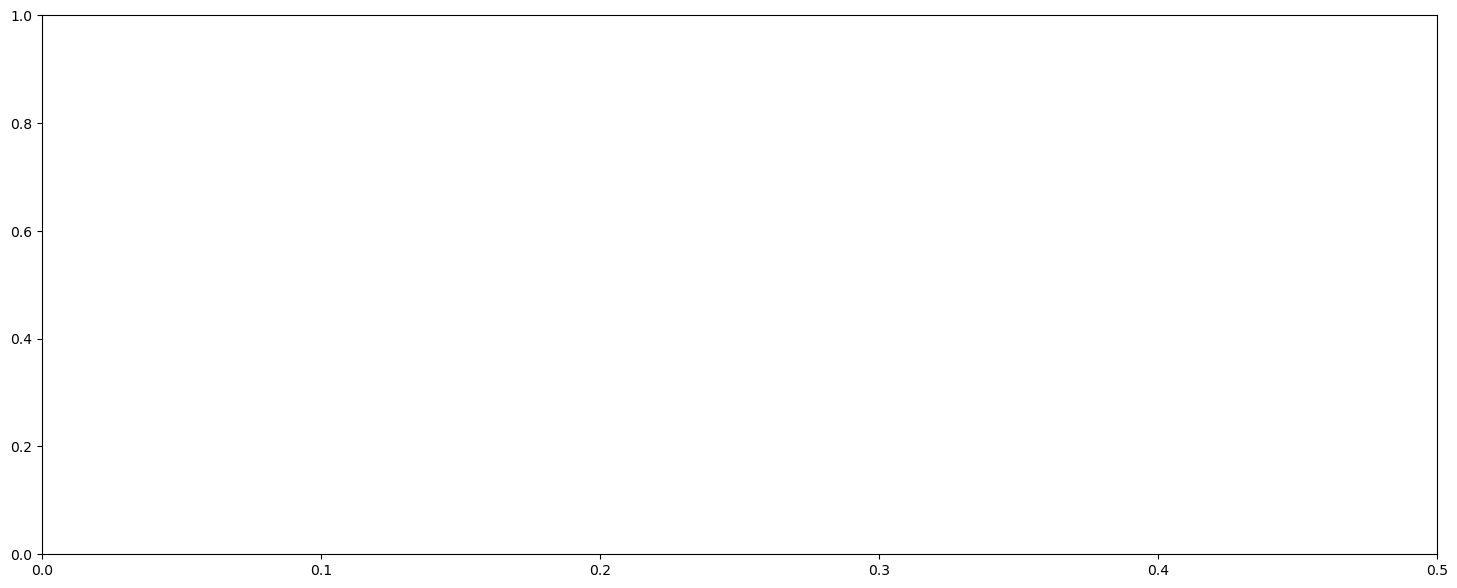

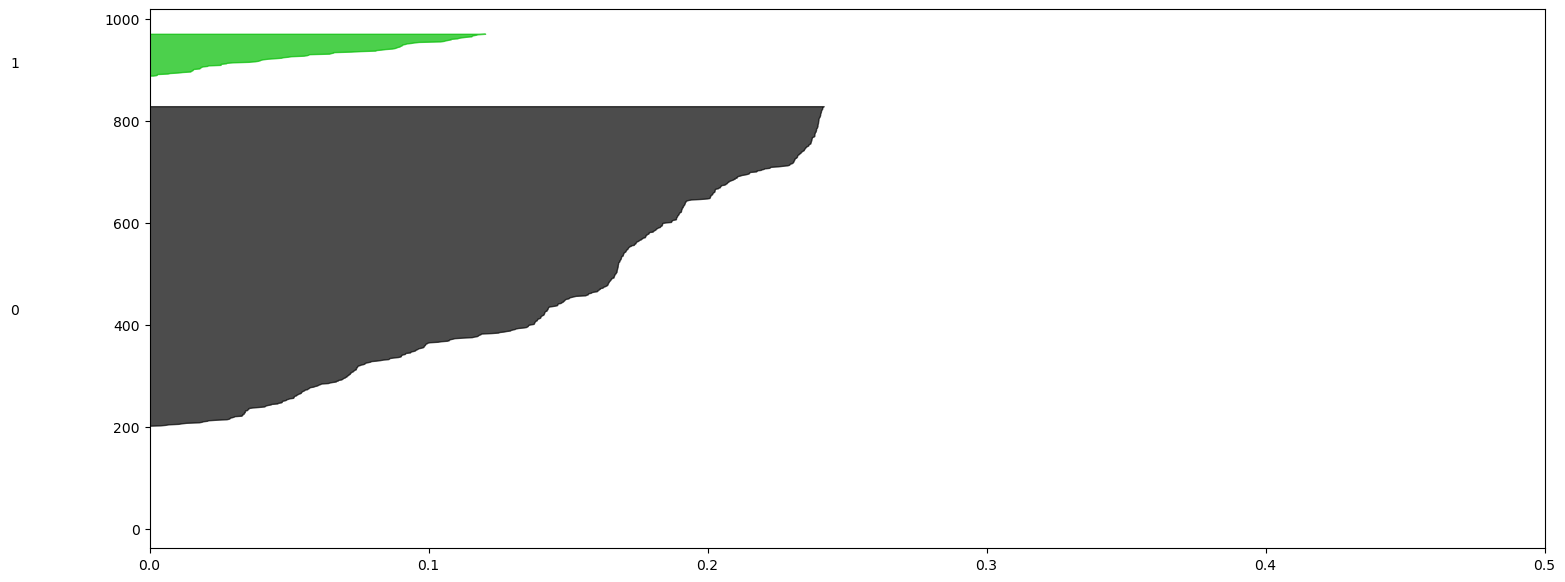

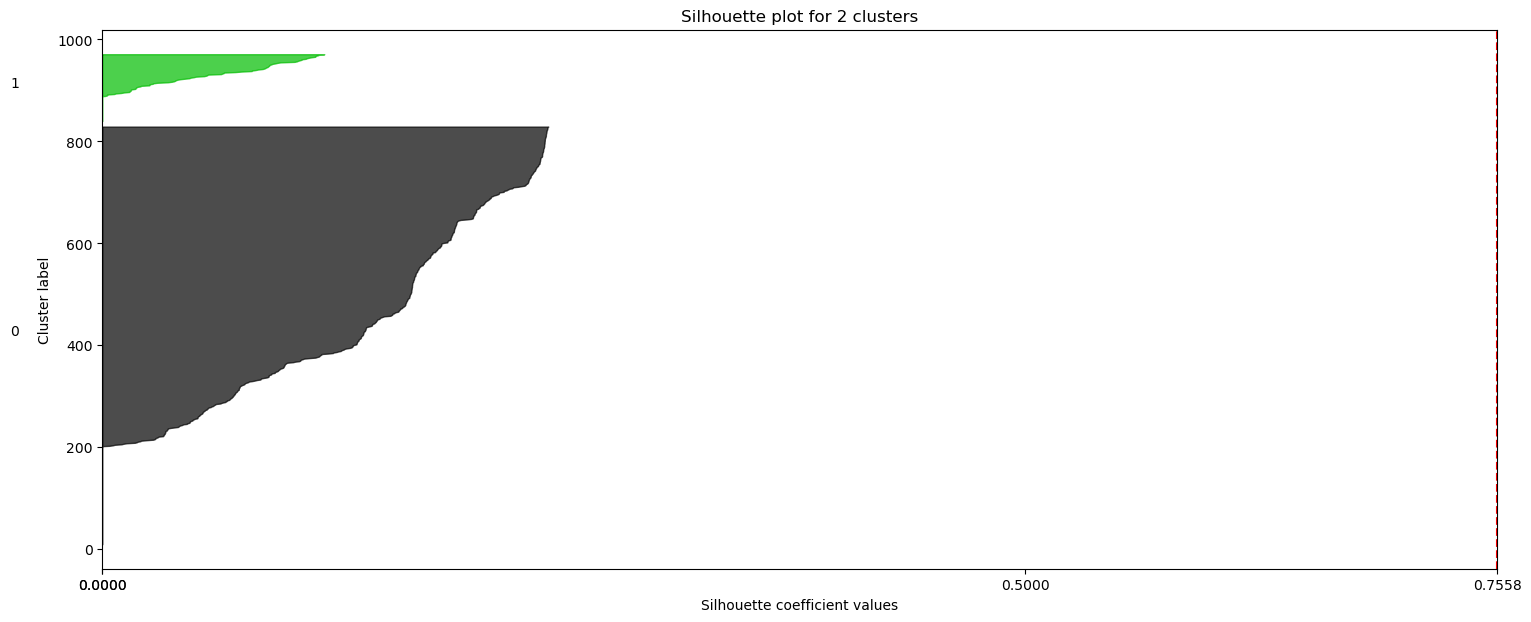

In [234]:
sample_silhouette_values = silhouette_samples(dataCopy.drop('Cluster', axis=1), cluster_labels)

# Create a silhouette plot
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

# Set the x-axis limits (silhouette scores can range from -1 to +1)
ax1.set_xlim([0, 0.5])

# Set the y-axis limits to be the size of the dataset plus some padding


y_lower = 10  # Starting point for the y-axis
for i in range(kmeans.n_clusters):
    #Aggregate the silhouette scores for cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    #Pick a color for the plot
    color = plt.cm.nipy_spectral(float(i) / kmeans.n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    #Label the silhouette plot with cluster numbers
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    #Compute the new y_lower for the next plot
    y_lower = y_upper + 10  # 10 for the gap between clusters

#Add labels and title to the plot
ax1.set_title(f"Silhouette plot for {kmeans.n_clusters} clusters")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster label")

#Vertical line for average silhouette score
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_xticks([0, 0, silhouette_avg, 0.5])


plt.show()